In [337]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from collections import OrderedDict
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import RobustScaler


## Data cleaning

In [338]:

sydney=pd.read_csv('SydneyHousePrices.csv',  index_col="Id", parse_dates =['Date'])
    

In [339]:
sydney['year'] = sydney['Date'].dt.year
sydney['month'] = sydney['Date'].dt.month

In [340]:
# Australia Housing Price Index
market_trend = pd.read_csv('housing_trend.csv')
aus_market= market_trend[(market_trend['LOCATION']=='AUS') & (market_trend['SUBJECT']=='NOMINAL')]
aus_market =aus_market.loc[:,['TIME','Value']]
aus_market=aus_market.rename(columns={'Value':'PRICE_INDEX'})
aus_market['year'] =pd.to_datetime(aus_market['TIME']).dt.year
aus_market['quarter'] =pd.to_datetime(aus_market['TIME']).dt.quarter
sydney['quarter'] = sydney['Date'].dt.quarter
aus_market=aus_market.drop(columns=['TIME'])
sydney=pd.merge(sydney,aus_market, on=['year','quarter'],how='left')
sydney=sydney.drop(columns=['quarter'])

In [341]:
sydney['car'].fillna(0, inplace=True)

In [342]:
max_room_n =10
sydney=sydney[sydney['bed']<=max_room_n]

In [343]:
lower=0.0009
upper=0.9999
lq = sydney.sellPrice.quantile(lower)
uq = sydney.sellPrice.quantile(upper)
sydney = sydney.loc[(sydney.sellPrice>=lq) & (sydney.sellPrice<=uq),:]

In [344]:
#sydney=sydney[(sydney['sellPrice']<400000000) & (sydney['sellPrice']>100000)]

In [345]:
propType_delete=['terrace', 'other', 'warehouse', 'acreage']     
sydney=sydney[~sydney.propType.isin(propType_delete)]

In [346]:
sydney=sydney[sydney['year']>2003]

In [347]:
sydney.dtypes

Date           datetime64[ns]
suburb                 object
postalCode              int64
sellPrice               int64
bed                   float64
bath                    int64
car                   float64
propType               object
year                    int64
month                   int64
PRICE_INDEX           float64
dtype: object

In [348]:
sydney.head()

,Date,suburb,postalCode,sellPrice,bed,bath,car,propType,year,month,PRICE_INDEX
0,2019-06-19,Avalon Beach,2107,1210000,4.0,2,2.0,house,2019,6,105.511806
1,2019-06-13,Avalon Beach,2107,2250000,4.0,3,4.0,house,2019,6,105.511806
2,2019-06-07,Whale Beach,2107,2920000,3.0,3,2.0,house,2019,6,105.511806
3,2019-05-28,Avalon Beach,2107,1530000,3.0,1,2.0,house,2019,5,105.511806
4,2019-05-22,Whale Beach,2107,8000000,5.0,4,4.0,house,2019,5,105.511806


## EDA

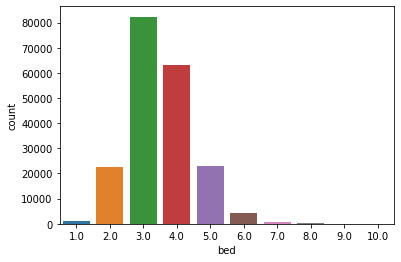

In [349]:
#Vilken sorts hus tar upp störst andel av marknaden?/Vad är den mest förekommande storleken på hus i antal rum? 
sns.countplot(x=sydney['bed'], data=sydney)
plt.show()
#Tre sovrum är det hus som har sålts mest genom åren i Sydney

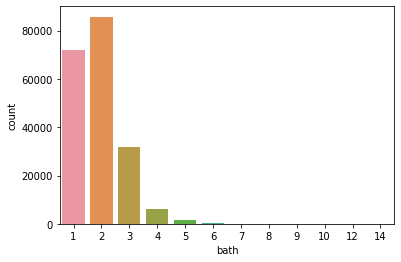

In [350]:
sns.countplot(x=sydney['bath'], data=sydney)
plt.show()
#Hus med två badrum är vanligast, med ett badrum en nära tvåa.

In [351]:
#Median price per bed
bed_df = sydney.groupby('bed').agg({'sellPrice':'median', 'propType':'count'}).sort_values(by='bed', ascending=True)
bed_df.columns = ['Median Price', 'No.Transactions']
bed_df = bed_df.rename_axis('No.Beds').reset_index()
bed_df


,No.Beds,Median Price,No.Transactions
0,1.0,695000.0,1191
1,2.0,792000.0,22615
2,3.0,875000.0,82325
3,4.0,1110000.0,62993
4,5.0,1500000.0,22903
5,6.0,1649000.0,4096
6,7.0,1658500.0,754
7,8.0,1686500.0,268
8,9.0,1840000.0,98
9,10.0,1925000.0,58


In [352]:
fig = px.histogram(bed_df, x='No.Beds', y = 'Median Price', nbins=20)
fig.show()

In [353]:
#Median price per suburb and bed
suburb_bed_df = sydney.groupby(['suburb', 'bed']).agg({'sellPrice':'median', 'propType':'count'}).sort_values(by=['bed', 'suburb'], ascending=True)
suburb_bed_df.columns = ['Median Price', 'No.Transactions']
suburb_bed_df = suburb_bed_df.rename_axis(['Suburb','No.Beds']).reset_index()
suburb_bed_df

,Suburb,No.Beds,Median Price,No.Transactions
0,Alexandria,1.0,710000.0,33
1,Ambarvale,1.0,335000.0,1
2,Annandale,1.0,775000.0,34
3,Annangrove,1.0,3525000.0,2
4,Arncliffe,1.0,870000.0,3
...,...,...,...,...
3880,Summer Hill,10.0,2010000.0,1
3881,Sydenham,10.0,919000.0,2
3882,Tennyson Point,10.0,2466500.0,1
3883,Vaucluse,10.0,4250000.0,1


In [354]:
#Median price per suburb only
suburb_df = sydney.groupby('suburb').agg({'sellPrice':'median', 'propType':'count'}).sort_values(by='suburb', ascending=True)
suburb_df.columns = ['Median Price', 'No.Transactions']
suburb_df = suburb_df.rename_axis('Suburb').reset_index()
suburb_df

,Suburb,Median Price,No.Transactions
0,Abbotsbury,975000.0,125
1,Abbotsford,1285000.0,235
2,Agnes Banks,712500.0,46
3,Airds,505000.0,31
4,Alexandria,1036000.0,706
...,...,...,...
678,Yarrawarrah,1003000.0,65
679,Yellow Rock,660000.0,51
680,Yennora,700000.0,31
681,Yowie Bay,1363500.0,214


In [355]:
#Top 10 most expensive suburbs in Sydney
suburb_df = sydney.groupby('suburb').agg({'sellPrice':'median'}).sort_values(by='sellPrice', ascending=False).head(10)
suburb_df.columns = ['Median Price']
suburb_df = suburb_df.rename_axis('Suburb').reset_index()
suburb_df

,Suburb,Median Price
0,Point Piper,6825000.0
1,Collaroy Beach,6575000.0
2,Darling Point,4700000.0
3,Woolwich,4000000.0
4,Bellevue Hill,3750000.0
5,Kurraba Point,3650000.0
6,Vaucluse,3600000.0
7,Cremorne Point,3325000.0
8,Longueville,3180000.0
9,Tamarama,3150000.0


In [356]:
fig = px.histogram(suburb_df, x='Suburb', y = 'Median Price')
fig.show()

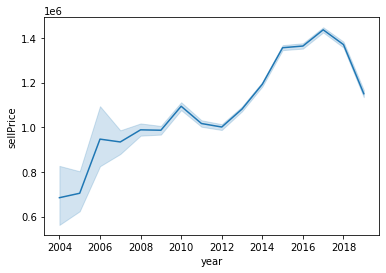

In [357]:
#Finns det några mönster/trender som påverkas av (som beror på) tidpunkt?.
#Graph på priset genom åren & månader
sns.lineplot(x=sydney['year'], y=sydney['sellPrice'])
plt.show()

In [358]:
#Get median price per year
yearly_median = sydney.groupby('year').agg({'sellPrice':'median'}).sort_values(by='year', ascending=True)
yearly_median.columns = ['Median Price']
yearly_median = yearly_median.rename_axis('Year').reset_index()
yearly_median

,Year,Median Price
0,2004,507500.0
1,2005,520000.0
2,2006,597500.0
3,2007,731000.0
4,2008,770000.0
5,2009,765000.0
6,2010,870000.0
7,2011,835000.0
8,2012,826000.0
9,2013,900000.0


In [359]:
fig = px.histogram(yearly_median, x='Year', y = 'Median Price', nbins=20)
fig.update_layout(bargap=0.3)
fig.show()

In [360]:
#Get median price per month
monthly_median = sydney.groupby('month').agg({'sellPrice':'median'}).sort_values(by='month', ascending=True)
monthly_median.columns = ['Median Price']
monthly_median = monthly_median.rename_axis('Month').reset_index()
monthly_median

,Month,Median Price
0,1,828888.0
1,2,990000.0
2,3,1032250.0
3,4,975000.0
4,5,985000.0
5,6,990000.0
6,7,930000.0
7,8,980000.0
8,9,1040000.0
9,10,1008000.0


In [361]:
monthly_median = monthly_median.replace([1,2,3,4,5,6,7,8,9,10,11,12], ['Jan', 'Feb', 'Mar', 'Apr', 'Maj', 'Jun', 'Jul', 'Aug', 'Sep', 'Okt', 'Nov', 'Dec'])

In [362]:
fig = px.histogram(monthly_median, x='Month', y = 'Median Price')
fig.show()

In [363]:
'''Looking at monthly prices it's not a clear period of the year where prices tend to be higher but we can see that January is the slowest month
while september is the month with most sales.'''


"Looking at monthly prices it's not a clear period of the year where prices tend to be higher but we can see that January is the slowest month\nwhile september is the month with most sales."

In [364]:
sydney.corr()["sellPrice"]

postalCode    -0.321100
sellPrice      1.000000
bed            0.346854
bath           0.458367
car            0.197139
year           0.141908
month          0.013419
PRICE_INDEX    0.167246
Name: sellPrice, dtype: float64

## ML

#### ML prep 

In [365]:
suburb_group_list = sydney.groupby('suburb')['sellPrice'].mean().sort_values(ascending=False).astype('int')
g1=list (suburb_group_list[suburb_group_list<500000].index) 
g2=list(suburb_group_list[(suburb_group_list<1000000) & (suburb_group_list>=500000)].index) 
g3=list(suburb_group_list[(suburb_group_list<1500000) & (suburb_group_list>=1000000)].index)
g4=list(suburb_group_list[(suburb_group_list>=1500000) & (suburb_group_list<2000000)].index)
g5=list(suburb_group_list[suburb_group_list>=2000000].index)

In [366]:
sydney.loc[sydney[sydney["suburb"].isin(g1)].index,'sub_gr']=1
sydney.loc[sydney[sydney["suburb"].isin(g2)].index,'sub_gr']=2
sydney.loc[sydney[sydney["suburb"].isin(g3)].index,'sub_gr']=3
sydney.loc[sydney[sydney["suburb"].isin(g4)].index,'sub_gr']=4
sydney.loc[sydney[sydney["suburb"].isin(g5)].index,'sub_gr']=5

In [367]:
sydney.head()

,Date,suburb,postalCode,sellPrice,bed,bath,car,propType,year,month,PRICE_INDEX,sub_gr
0,2019-06-19,Avalon Beach,2107,1210000,4.0,2,2.0,house,2019,6,105.511806,4.0
1,2019-06-13,Avalon Beach,2107,2250000,4.0,3,4.0,house,2019,6,105.511806,4.0
2,2019-06-07,Whale Beach,2107,2920000,3.0,3,2.0,house,2019,6,105.511806,5.0
3,2019-05-28,Avalon Beach,2107,1530000,3.0,1,2.0,house,2019,5,105.511806,4.0
4,2019-05-22,Whale Beach,2107,8000000,5.0,4,4.0,house,2019,5,105.511806,5.0


In [368]:
ml_df=pd.concat([sydney, pd.get_dummies(sydney['propType'], prefix='pt', drop_first=True)],axis=1)
ml_df.drop(['propType'],axis=1, inplace=True)

In [369]:
ml_df.head()

,Date,suburb,postalCode,sellPrice,bed,bath,car,year,month,PRICE_INDEX,sub_gr,pt_house,pt_townhouse,pt_villa
0,2019-06-19,Avalon Beach,2107,1210000,4.0,2,2.0,2019,6,105.511806,4.0,1,0,0
1,2019-06-13,Avalon Beach,2107,2250000,4.0,3,4.0,2019,6,105.511806,4.0,1,0,0
2,2019-06-07,Whale Beach,2107,2920000,3.0,3,2.0,2019,6,105.511806,5.0,1,0,0
3,2019-05-28,Avalon Beach,2107,1530000,3.0,1,2.0,2019,5,105.511806,4.0,1,0,0
4,2019-05-22,Whale Beach,2107,8000000,5.0,4,4.0,2019,5,105.511806,5.0,1,0,0


In [370]:
ml_df = ml_df.drop('Date', axis=1)
ml_df = ml_df.drop('suburb', axis=1)

In [371]:
ml_df.head()

,postalCode,sellPrice,bed,bath,car,year,month,PRICE_INDEX,sub_gr,pt_house,pt_townhouse,pt_villa
0,2107,1210000,4.0,2,2.0,2019,6,105.511806,4.0,1,0,0
1,2107,2250000,4.0,3,4.0,2019,6,105.511806,4.0,1,0,0
2,2107,2920000,3.0,3,2.0,2019,6,105.511806,5.0,1,0,0
3,2107,1530000,3.0,1,2.0,2019,5,105.511806,4.0,1,0,0
4,2107,8000000,5.0,4,4.0,2019,5,105.511806,5.0,1,0,0


#### Models

In [372]:
#Splitting into test and train using our top correlaed features
target_name = 'sellPrice'
X = ml_df.drop('sellPrice', axis=1)
robust_scaler = RobustScaler()
X = robust_scaler.fit_transform(X)
y = ml_df[target_name]
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [373]:
#Skapa ett par ML modeller för att förutspå priser

#Linear regression
linear_regression = LinearRegression()
linear_regression.fit(x_train, y_train)
linear_result = cross_validate(linear_regression, X, y, 
                                scoring=('neg_mean_squared_error', 'r2'),
                                cv=10, n_jobs=-1, return_train_score=True)

In [374]:
print(f"Mean MSLE train data: {-np.mean(linear_result['train_neg_mean_squared_error'])}")
print(f"Mean MSLE test data: {-np.mean(linear_result['test_neg_mean_squared_error'])}")

print(f"Mean R2 train: {np.mean(linear_result['train_r2'])}")
print(f"Mean R2 test data: {np.mean(linear_result['test_r2'])}")

Mean MSLE train data: 388448042746.7977
Mean MSLE test data: 392280754974.3428
Mean R2 train: 0.5372074085683762
Mean R2 test data: 0.5288736660207563


In [375]:
rf = RandomForestRegressor(max_depth=10)
rf.fit(x_train, y_train)
rf_result = cross_validate(rf, X, y, 
                                scoring=('neg_mean_squared_error', 'r2'),
                                cv=10, n_jobs=-1, return_train_score=True)

In [376]:
print(f"Mean MSLE train data: {-np.mean(rf_result['train_neg_mean_squared_error'])}")
print(f"Mean MSLE test data: {-np.mean(rf_result['test_neg_mean_squared_error'])}")

print(f"Mean R2 train: {np.mean(rf_result['train_r2'])}")
print(f"Mean R2 test data: {np.mean(rf_result['test_r2'])}")

Mean MSLE train data: 207075103722.50735
Mean MSLE test data: 298456574531.0942
Mean R2 train: 0.7532232338784295
Mean R2 test data: 0.638051651388638


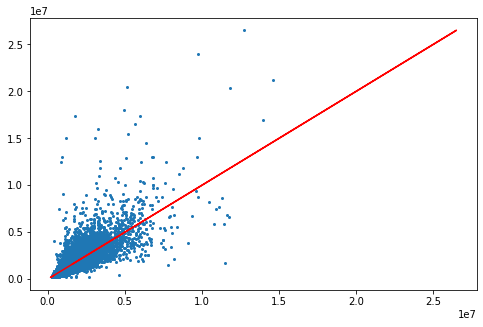

In [377]:
fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(rf.predict(x_test), y_test, s=4)
ax.plot(y_test, y_test, color='red')

In [378]:
rf.score(x_test, y_test)

0.6819029496098747

In [379]:
#Förutspå pris på specifikt hus i båda städerna för att se prisskillnaden